# Build  spectra for AuxTel : Part 1

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : June 16 2021
- version v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels anaconda3_auxtel (with libradtran) and anaconda3_auxtel_v2 (no libradtran)

# Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
from iminuit import Minuit
import iminuit

In [7]:
iminuit.__version__

'2.2.0'

In [8]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [9]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

# Path

In [10]:
path_auxtel="/sps/lsst/groups/auxtel"
path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
path_spectractor_config=os.path.join(path_spectractor,"config")
path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")

# Function

In [11]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^Cor_holo4_003_*_(.*)_.*[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [12]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

# Logbook for file selection

In [13]:
filename_logbook='logbooks/auxtelholologbook_2021_07_06_v2.0.csv'

In [14]:
df=pd.read_csv(filename_logbook,index_col=0)

In [15]:
pd.set_option('display.max_rows', None)

In [16]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-07T01:16:33.033,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000098.fits,98,HD120144,RG610,holo4_003,1.112792,20.0,...,7.0,16.0,11.6,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2021-07-07T01:17:01.054,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000099.fits,99,HD120144,RG610,holo4_003,1.113402,20.0,...,7.0,16.0,11.6,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2021-07-07T01:17:25.525,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000100.fits,100,HD120144,RG610,holo4_003,1.113971,20.0,...,7.0,16.0,11.6,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2021-07-07T01:17:50.010,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000101.fits,101,HD120144,RG610,holo4_003,1.114548,20.0,...,7.0,15.0,13.1,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2021-07-07T01:18:14.601,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000102.fits,102,HD120144,RG610,holo4_003,1.115124,20.0,...,7.0,15.0,13.1,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2021-07-07T01:18:38.991,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000103.fits,103,HD120144,RG610,holo4_003,1.115701,20.0,...,7.1,15.0,10.9,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2021-07-07T01:19:03.593,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000104.fits,104,HD120144,RG610,holo4_003,1.116286,20.0,...,7.1,15.0,10.9,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2021-07-07T01:19:27.983,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000105.fits,105,HD120144,RG610,holo4_003,1.116869,20.0,...,7.1,15.0,10.9,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2021-07-07T01:19:52.570,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000106.fits,106,HD120144,RG610,holo4_003,1.117460,20.0,...,7.2,14.0,9.9,NaN,NaN,NaN,NaN,,NaN,NaN


# Selection of input file

In [63]:
idx=3

In [64]:
myhome=os.getenv("HOME")

In [65]:
dir_images=path_images

In [66]:
filename_image=df['file'][idx]
filename_image

'Cor_holo4_003_RG610_HD120144_20210706_000100.fits'

In [67]:
file_target(filename_image)

'HD120144'

In [23]:
filename=os.path.join(dir_images,filename_image)
output_directory="./outputs_process_holo"
output_figures="figures_process_holo"
guess = [250,2600]
disperser_label = "holo4_003"
config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
target = file_target(filename_image)[0]

In [24]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)

# Configuration of the running mode

In [25]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [ ]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Load an image

In [68]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> parameters.OBS_ALTITUDE: 2.66299616375123	 <class 'float'>
x obs_latitude: -30.2446389756252	=> parameters.OBS_LATITUDE: -30.2446389756252	 <class 'float'>
x obs_diameter: 1.20	=> parameters.OBS_DIAMETER: 1.2 m	 <class 'astropy.units.quantity.Quantity'>
x obs_epoch: J2000.0	=> parameters.OBS_EPOCH: J2000.0	 <class 'str'>
x obs_transmission_systematics: 0.005	=> parameters.OBS_TRANSMISSION_SYSTEMATICS: 0.005	 <c

2021-07-07 19:16:14  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000098.fits...
2021-07-07 19:16:14  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000098.fits...
2021-07-07 19:16:14  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-07-07 19:16:14  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-07-07 19:16:14  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-07-07 19:16:14  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-07-07 19:16:14  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-07-07 19:16:14  Hologram

## Show relevant parameters

In [27]:
parameters.OBS_NAME

'AUXTEL'

In [28]:
parameters.DISPERSER_DIR

'/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [29]:
parameters.DISTANCE2CCD

182.0

In [30]:
parameters.LAMBDA_MIN 

563

In [31]:
parameters.LAMBDA_MAX 

1095

In [32]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [33]:
image.filter_label

'RG610'

In [34]:
image.header["FILTER"]

'RG610'

In [ ]:
#image.header

# Plot image and find the target position

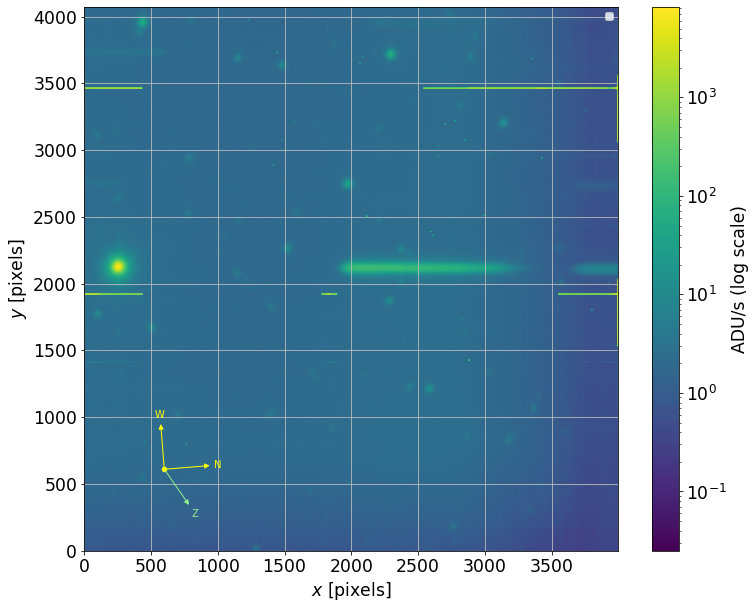

In [69]:
image.plot_image(figsize=(12, 10),scale="log")

In [62]:
filename_image

'Cor_holo4_003_RG610_HD120144_20210706_000099.fits'

In [37]:
guess = [256.15, 2128.11] # filename_image=df['file'][0] , Cor_holo4_003_RG610_HD120144_20210706_000098.fits
guess = [256.15, 2128.11] # filename_image=df['file'][1] , Cor_holo4_003_RG610_HD120144_20210706_000099.fits
guess = [256.15, 2128.11] # filename_image=df['file'][2] , Cor_holo4_003_RG610_HD120144_20210706_000100.fits

In [38]:
filename_image

'Cor_holo4_003_RG610_HD120144_20210706_000098.fits'

2021-07-07 19:17:13  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1       
    ------------------ -------------------- -------------------
    29.267741325094935 -0.16905753177843655 0.11287718532210887
2021-07-07 19:17:13  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1       
    ------------------ -------------------- -------------------
    29.267741325094935 -0.16905753177843655 0.11287718532210887
2021-07-07 19:17:13  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=1.25e-05.
2021-07-07 19:17:13  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent termina

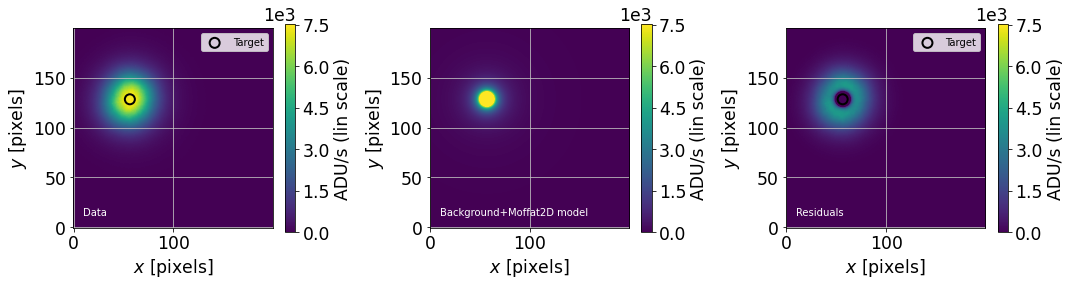

2021-07-07 19:17:14  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=5e-05.
2021-07-07 19:17:14  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=5e-05.


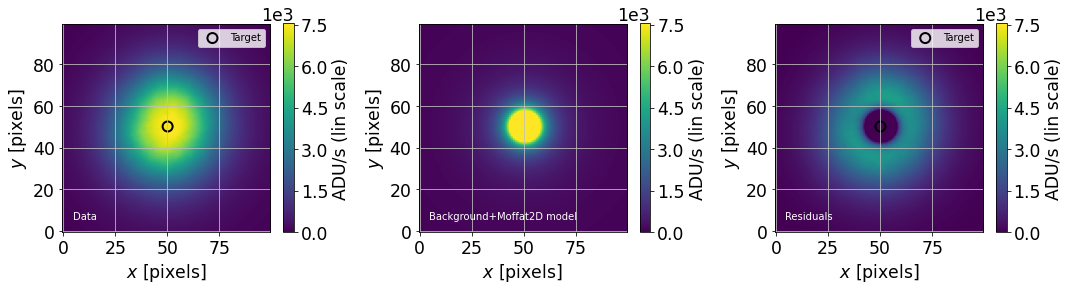

2021-07-07 19:17:14  Image      find_target          INFO   
	X,Y target position in pixels: 256.155,2128.107
2021-07-07 19:17:14  Image      find_target          INFO   
	X,Y target position in pixels: 256.155,2128.107


In [70]:

parameters.VERBOSE = True
parameters.DEBUG = True
x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)

In [71]:
print(x1,y1)

256.1546904819122 2128.1070284127036


In [41]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [42]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [43]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [44]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [45]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [46]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [47]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [48]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [49]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [50]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [51]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [52]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [ ]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

Text(0.05, 0.2, 'normal  : p_test   = 0.000e+00\n             : p_test_x = 3.087e-09\n             : p_test_y = 3.190e-08')

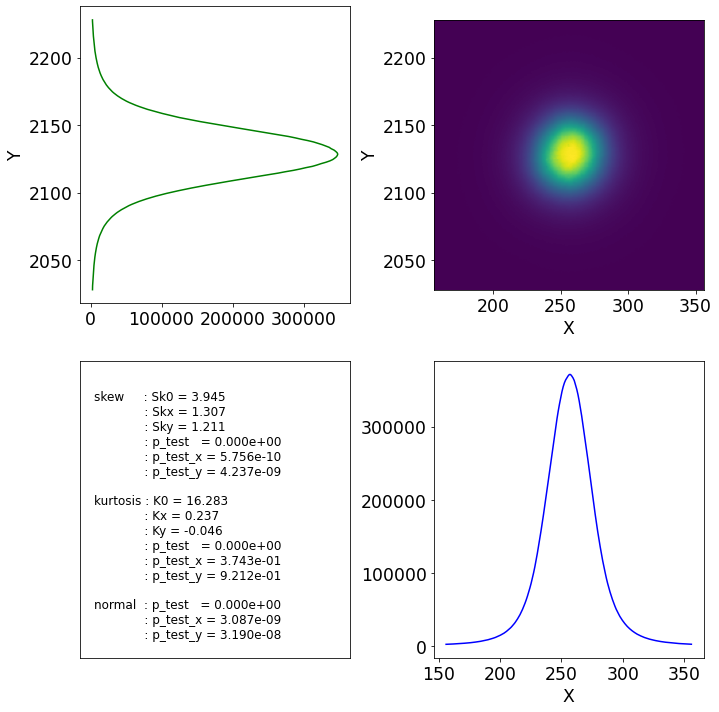

In [53]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)

# Go for spectrum reconstruction

2021-07-07 19:08:33  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-07-07 19:08:33  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000098.fits...
2021-07-07 19:08:33  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> parameters.OBS_ALTITUDE: 2.66299616375123	 <class 'float'>
x obs_latitude: -30.2446389756252	=> parameters.OBS_LATITUDE: -30.2446389756252	 <class 'float'>
x obs_diameter: 1.20	=> parameters.OBS_DIAMETER: 1.2 m	 <class 'astropy.units.quantity.Quantity'>
x obs_epoch: J2000.0	=> parameters.OBS_EPOCH: J2000.0	 <class 'str'>
x obs_transmission_systematics: 0.005	=> parameters.OBS_TRANSMISSION_SYSTEMATICS: 0.005	 <c

2021-07-07 19:08:33  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-07-07 19:08:33  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-07-07 19:08:33  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-07-07 19:08:38  TelescopeTransmission reset_lambda_range   INFO   
	With filter RG610, set parameters.LAMBDA_MIN=563 and parameters.LAMBDA_MAX=1095.
2021-07-07 19:08:38  urllib3.connectionpool _get_conn            DEBUG  Resetting dropped connection: simbad.u-strasbg.fr
2021-07-07 19:08:38  urllib3.connectionpool _make_request        DEBUG  http://simbad.u-strasbg.fr:80 "POST /simbad/sim-script HTTP/1.1" 200 None
2021-07-07 19:08:38  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           

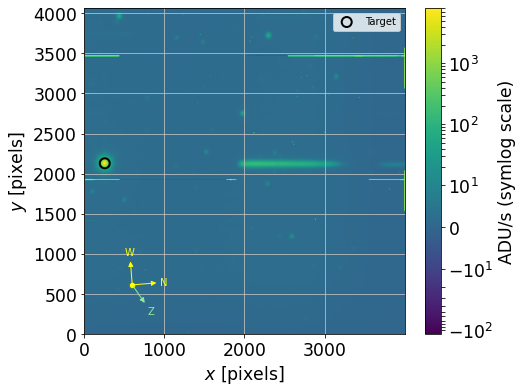

2021-07-07 19:08:43  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 256.15469048 2128.10702841]...
2021-07-07 19:08:43  spectractor.extractor.images find_target          INFO   
	No WCS /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000098_wcs/Cor_holo4_003_RG610_HD120144_20210706_000098.wcs available, use 2D fit to find target pixel position.
2021-07-07 19:08:43  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                  c0_1         
    ----------------- -------------------- ----------------------
    27.40155104569645 0.005196836405625207 -0.0008938144669893818
2021-07-07 19:08:44  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=1

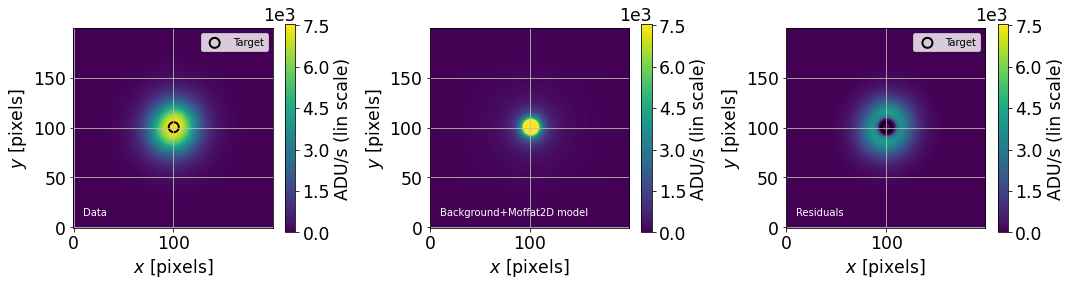

2021-07-07 19:08:44  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=5e-05.


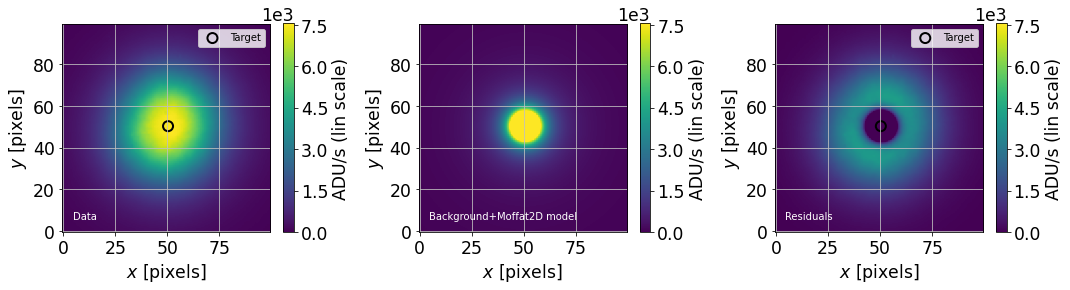

2021-07-07 19:08:45  Image      find_target          INFO   
	X,Y target position in pixels: 256.356,2128.260


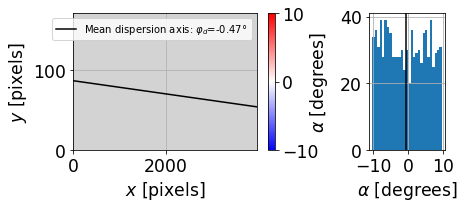

2021-07-07 19:08:46  Image      turn_image           INFO   
	Rotate the image with angle theta=-0.47 degree
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1713: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=10)


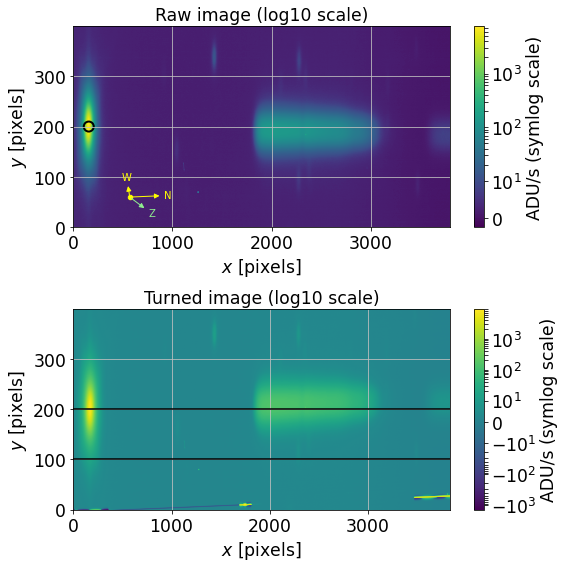

2021-07-07 19:08:56  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-07-07 19:08:57  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0              c1_0               c0_1       
    ----------------- ----------------- -------------------
    510.2737288803513 0.446755416232098 0.26220452013448425
2021-07-07 19:08:57  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.
2021-07-07 19:08:57  Image      find_target_Moffat2D WARNING 
	X=58.01, Y=52.74 target position determination probably wrong: 8.1 pixels from profile detection (50.39, 50.14)


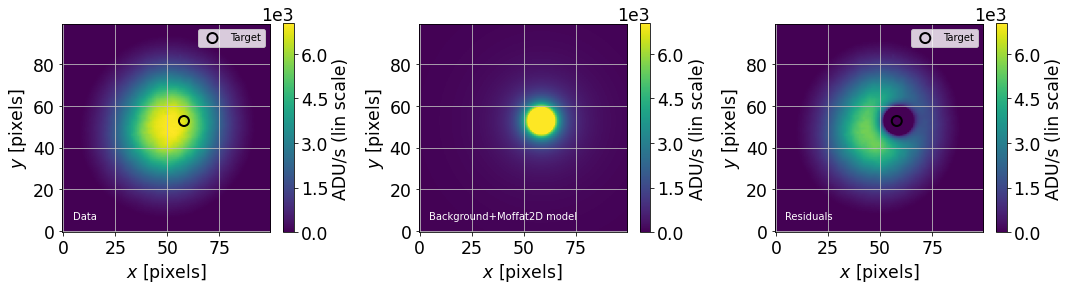

2021-07-07 19:08:58  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 9 iterations because the relative change of cost is below ftol=0.0002.


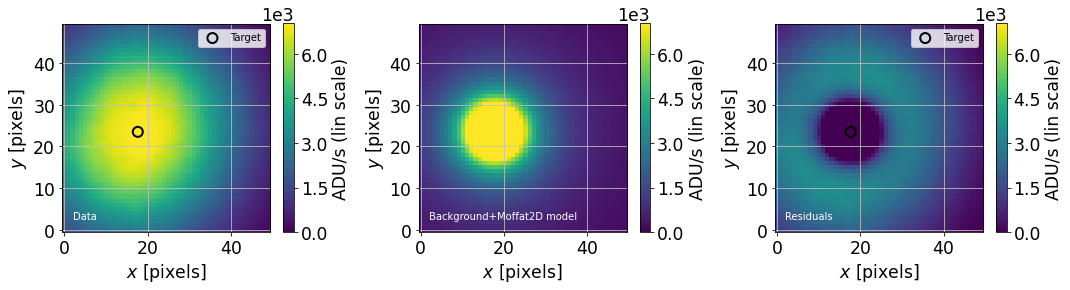

2021-07-07 19:08:58  Image      find_target          INFO   
	X,Y target position in pixels: 272.663,2130.513
2021-07-07 19:08:58  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-07-07 19:08:58  TelescopeTransmission reset_lambda_range   INFO   
	With filter RG610, set parameters.LAMBDA_MIN=565.0000000000005 and parameters.LAMBDA_MAX=1089.8000000001198.
2021-07-07 19:08:58  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*40 pixels and background from 140 to 180 pixels
2021-07-07 19:08:59  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [1883:3412,1950:2310] (size (1529, 360))


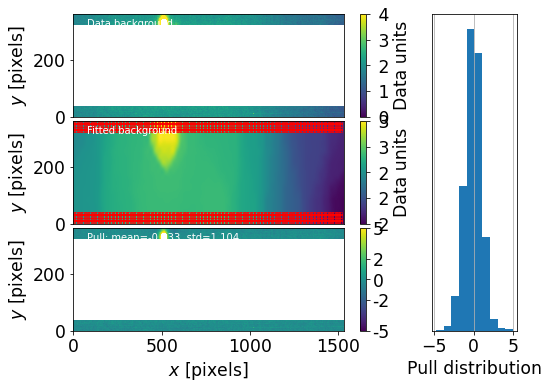

2021-07-07 19:09:01  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


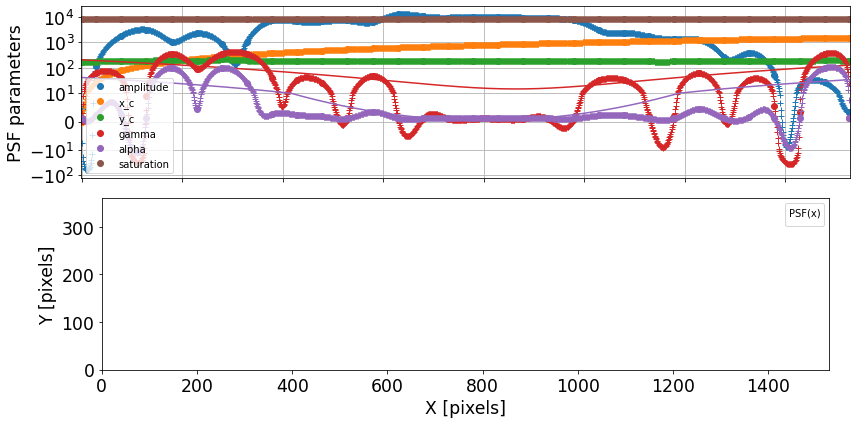

2021-07-07 19:09:26  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=3.6975e+07 initial chisq_red=302.28
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-1.28118804  0.27206029 -3.68656508 -0.45881791 -5.58216321 -3.75358755
 -3.43733086 -1.67346916 -4.95088397]
	New parameters: [  4.41404876  -3.15745119   6.48527903  37.25324833 -29.09701174
  68.87691253   1.71110533  -2.81978869   3.75740034]
	Final cost=2.5783e+07 final chisq_red=210.78 computed in 1.60s
2021-07-07 19:09:28  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=2.5783e+07 initial chisq_red=210.78
		 Line search: alpha_min=4.08 iter=0 funcalls=8
	Parameter shifts: [ -3.16772281  -3.66924812  -9.2868555   46.1854707  -34.56224606
  73.43735884  -4.79550352 -22.07006347   0.53439542]
	New parameters: [  1.24632595  -6.82669931  -2.80157646  83.43871903 -63.6592578
 142.31427137  -3.08439819 -24.88985216   4.29179575]
	Final cost=1.2663e+07 fina

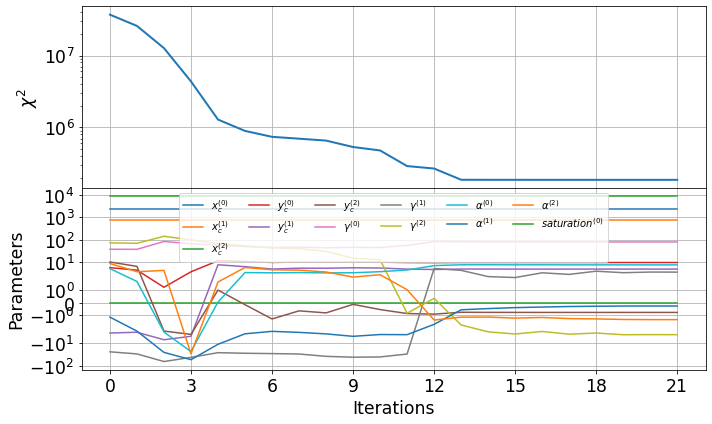

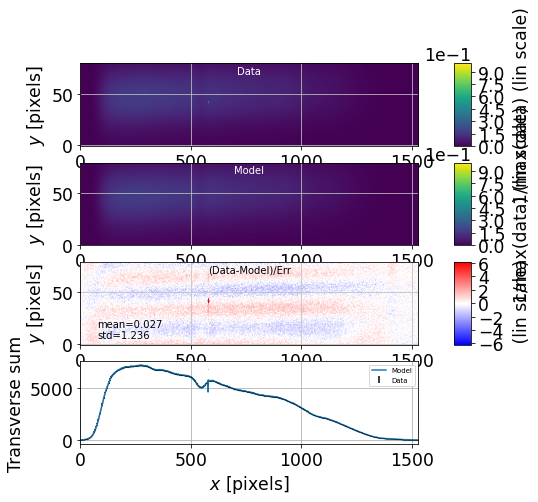

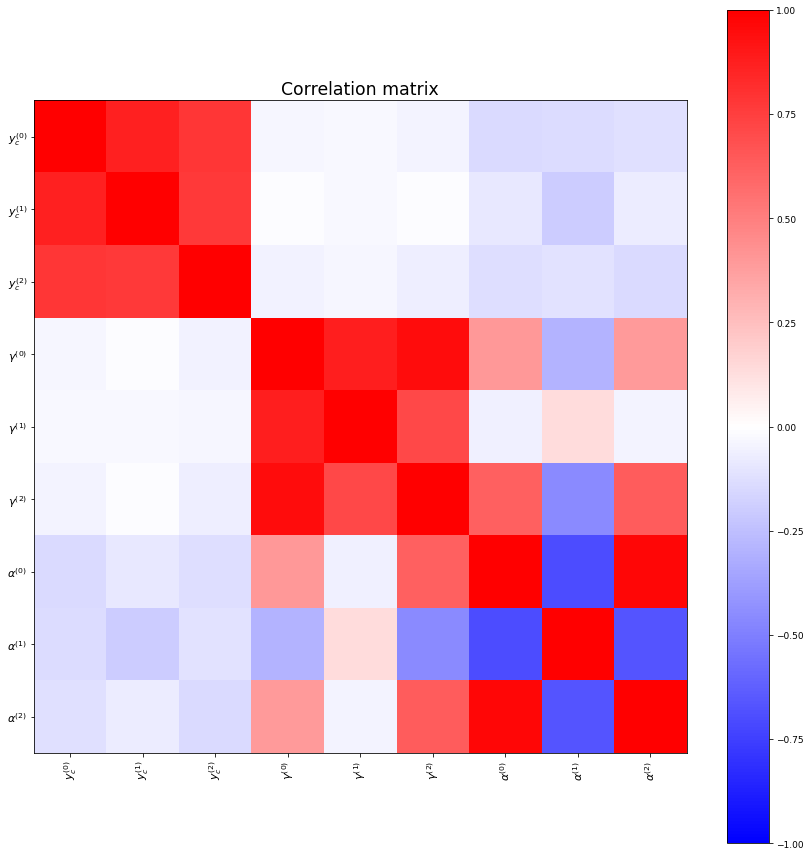

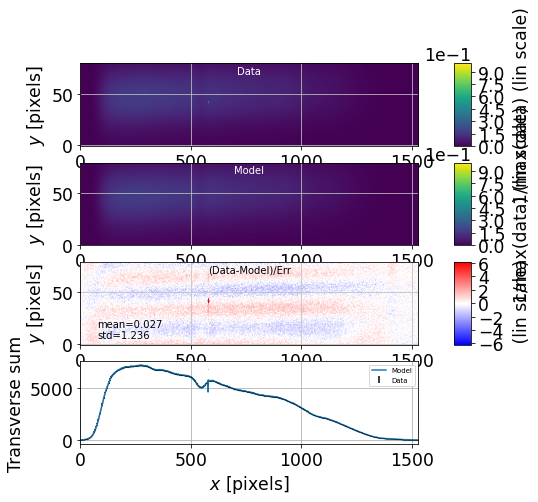

2021-07-07 19:10:10  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
     amplitude       x_c   ...         Dy         Dy_disp_axis
------------------- ------ ... ------------------ ------------
   8.98374677226558    0.0 ... 3.9528884060838436          0.0
  9.861110445542943    1.0 ... 3.9623437999618716          0.0
  9.333686380913607    2.0 ... 3.9717952371555896          0.0
 18.067966454153723    3.0 ...  3.981242717665026          0.0
 12.410402316842514    4.0 ... 3.9906862414901525          0.0
 10.665787932389431    5.0 ...  4.000125808630969          0.0
 14.986662112431445    6.0 ...  4.009561419087504          0.0
 16.410083049292215    7.0 ...  4.018993072859729          0.0
  11.89556397781664    8.0 ...  4.028420769947672          0.0
  21.44227268954256    9.0 ...  4.037844510351306          0.0
                ...    ... ...                ...          ...
 0.8454732056593639 1518.0 ... 13.750438140928026  

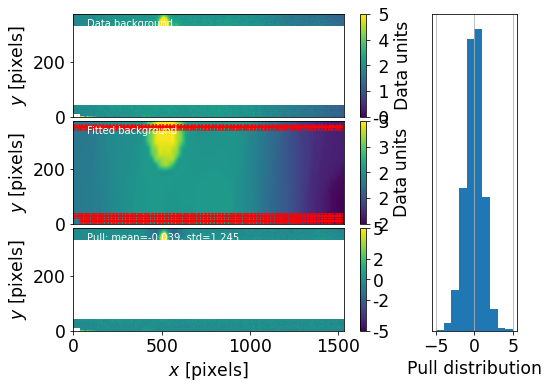

2021-07-07 19:10:13  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=2.330 ADU/s, RMS=0.545 ADU/s.
2021-07-07 19:10:13  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1866:3395,1923:2296] (size (1529, 373))
	New target position in spectrogram frame: [-1609.643841344672, 205.26009961938234]


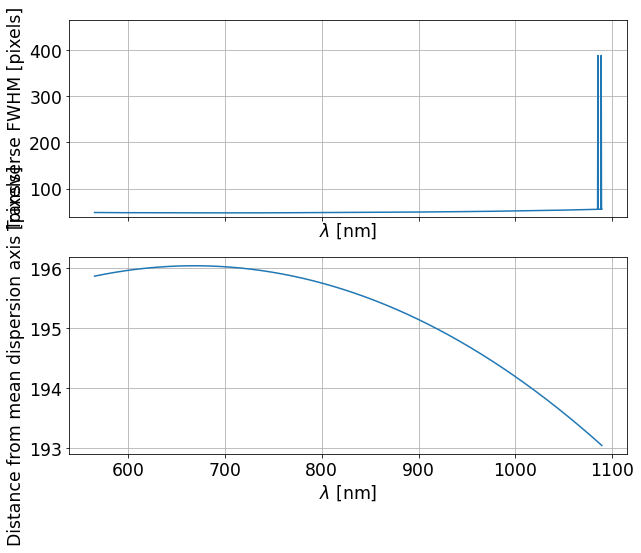

/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1713: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=10)


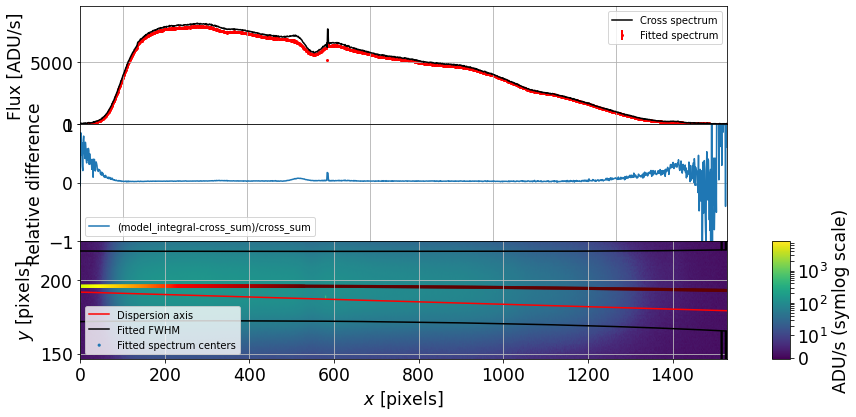

2021-07-07 19:10:15  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


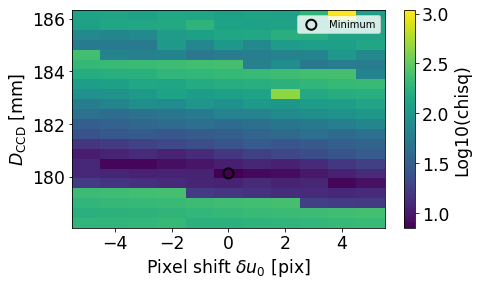

2021-07-07 19:10:44  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.112pix
	D = 180.107 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.5 sigma shift)
2021-07-07 19:10:44  astropy    _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-07-07 19:10:44  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_holo/Cor_holo4_003_RG610_HD120144_20210706_000098_spectrum.fits
2021-07-07 19:10:44  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_holo/Cor_holo4_003_RG610_HD120144_20210706_000098_spectrogram.fits


   Line   Tabulated  Detected   Shift    ...   Chisq   Eqwidth_mod Eqwidth_data
              nm        nm        nm     ...  reduced       nm          nm     
--------- --------- --------- ---------- ... --------- ----------- ------------
$H\alpha$     656.3  653.2161  -3.083888 ... 12.908303  0.81581616     3.884102
 $O_2(B)$   687.472  688.8779  1.4059532 ... 12.908303  0.15477933  0.083721876
              760.3 760.36993 0.06993902 ... 12.908303   1.9182034    2.2255535
    $O_2$     763.1  767.9606   4.860568 ... 12.908303  0.39308593    2.2141988
  $H_2 O$     935.0   939.064  4.0640063 ... 0.9243384   3.4515798    3.9824803


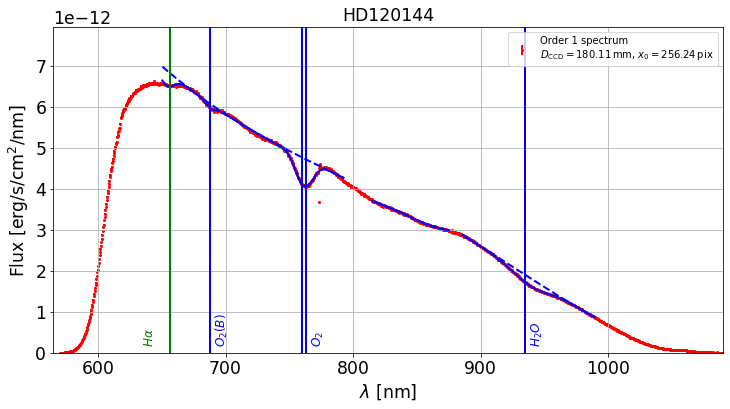

In [54]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

In [ ]:
!jupyter labextension list
